In [ ]:
!pip install pymaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 9.7 MB/s eta 0:00:00


Contour Thickness: 1
i1 Thresholds: (92.0, 155.0)
i12_minus_i1 Thresholds: (225.0, 346.0)
Contour Thickness: 2
i1 Thresholds: (92.0, 156.0)
i12_minus_i1 Thresholds: (173.0, 480.0)
Contour Thickness: 3
i1 Thresholds: (92.0, 157.0)
i12_minus_i1 Thresholds: (154.0, 547.0)
Contour Thickness: 4
i1 Thresholds: (92.0, 157.0)
i12_minus_i1 Thresholds: (154.0, 547.0)
Contour Thickness: 5
i1 Thresholds: (92.0, 159.0)
i12_minus_i1 Thresholds: (134.0, 653.0)
Contour Thickness: 6
i1 Thresholds: (92.0, 159.0)
i12_minus_i1 Thresholds: (134.0, 653.0)


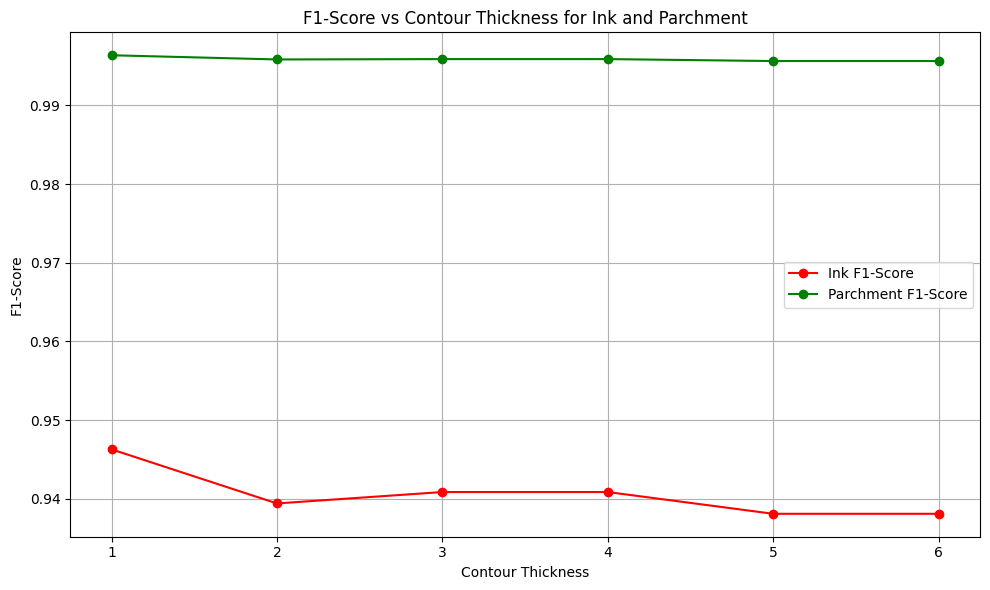

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow
import pandas as pd
import json

# Paths and directories
fragment = "124_001"
cropped_dir = '/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/cropped_124_001'
input_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/multispectral_images/"
output_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/MSEM_results/ablation/"

# Define output directories for different contour thicknesses
contour_thickness_dirs = {
    "ink": os.path.join(output_base, "ink_masks_with_contour_thicknesses"),
    "parchment": os.path.join(output_base, "parchment_masks_with_contour_thicknesses")
}

# Create output directories if they don't exist
for path in contour_thickness_dirs.values():
    os.makedirs(path, exist_ok=True)

# Load band images
i1 = cv2.imread(os.path.join(cropped_dir, "124_001_001.tif"), cv2.IMREAD_UNCHANGED).astype(np.float64)
i12 = cv2.imread(os.path.join(cropped_dir, "124_001_012.tif"), cv2.IMREAD_UNCHANGED).astype(np.float64)
i12_minus_i1 = i12 - i1

# Load ink and parchment masks
ink_masks_dir = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/ink_masks"
parchment_masks_dir = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/parchment_masks"
ink_mask_gt = cv2.imread(os.path.join(ink_masks_dir, "124_001.png"), cv2.IMREAD_GRAYSCALE)
parchment_mask_gt = cv2.imread(os.path.join(parchment_masks_dir, "124_001.png"), cv2.IMREAD_GRAYSCALE)


# Graph-cut segmentation function
def graph_cut_segmentation(imagetoseg, h, i):
    white_pixels_mask = imagetoseg > 0
    dist_transform_h = cv2.distanceTransform(255 - h, cv2.DIST_L2, 5)
    dist_transform_i = cv2.distanceTransform(255 - i, cv2.DIST_L2, 5)
    data_cost_h = np.where(white_pixels_mask, 1 / (1 + dist_transform_h), np.inf)
    data_cost_i = np.where(white_pixels_mask, 1 / (1 + dist_transform_i), np.inf)

    num_white_pixels = np.sum(white_pixels_mask)
    g = maxflow.Graph[float](num_white_pixels, num_white_pixels * 4)
    node_ids = g.add_nodes(num_white_pixels)

    white_pixel_indices = np.argwhere(white_pixels_mask)
    node_id_map = np.full(white_pixels_mask.shape, -1, dtype=int)
    node_id_map[white_pixels_mask] = node_ids

    for node_id, (y, x) in enumerate(white_pixel_indices):
        g.add_tedge(node_id, data_cost_h[y, x], data_cost_i[y, x])

    for y, x in white_pixel_indices:
        if y + 1 < white_pixels_mask.shape[0] and white_pixels_mask[y + 1, x]:
            g.add_edge(node_id_map[y, x], node_id_map[y + 1, x], 1, 1)
        if x + 1 < white_pixels_mask.shape[1] and white_pixels_mask[y, x + 1]:
            g.add_edge(node_id_map[y, x], node_id_map[y, x + 1], 1, 1)

    g.maxflow()
    result = np.zeros_like(white_pixels_mask, dtype=bool)
    for node_id, (y, x) in enumerate(white_pixel_indices):
        result[y, x] = g.get_segment(node_id)

    return result.astype(np.uint8) * 255

# Apply graph-cut segmentation for each contour thickness
contour_thresholds_all = {}

for thickness in [1, 2, 3, 4, 5, 6]:
    # Create ink contour mask with different thickness
    contours, _ = cv2.findContours(ink_mask_gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ink_contour_mask = np.zeros_like(ink_mask_gt, dtype=np.uint8)
    cv2.drawContours(ink_contour_mask, contours, -1, color=255, thickness=thickness)

    # Extract pixel values for contour regions (using a mask with 255 values for contours)
    contour_i1_values = i1[ink_contour_mask == 255]
    contour_diff_values = i12_minus_i1[ink_contour_mask == 255]

    # Calculate thresholds for contour intensities
    contour_thresholds = {
        "i1": (np.percentile(contour_i1_values, 10), np.percentile(contour_i1_values, 90)),
        "i12_minus_i1": (np.percentile(contour_diff_values, 10), np.percentile(contour_diff_values, 90))}
    print(f"Contour Thickness: {thickness}")
    print(f"i1 Thresholds: {contour_thresholds['i1']}")
    print(f"i12_minus_i1 Thresholds: {contour_thresholds['i12_minus_i1']}")

    # Save contour thresholds for later use
    contour_thresholds_all[thickness] = contour_thresholds

    # Create masks for parchment, ink, and ink contours
    parchment_mask = (i12 - i1 > 313).astype(np.uint8) * 255
    ink_mask = np.uint8((i12 - i1 > 78) & (i12 - i1 <= 280) & (i1 > 92) & (i1 <= 150)) * 255

    # Unpack thresholds from contour_thresholds dictionary
    i1_lower, i1_upper = contour_thresholds["i1"]
    i12_minus_i1_lower, i12_minus_i1_upper = contour_thresholds["i12_minus_i1"]

    # Create the ink contour mask using the thresholds from contour_thresholds
    ink_contour_mask = np.uint8(
        (i12 - i1 > i12_minus_i1_lower) & (i12 - i1 <= i12_minus_i1_upper) &
        (i1 > i1_lower) & (i1 <= i1_upper)) * 255

    # Apply graph-cut segmentation
    inverse_parchment_mask = cv2.bitwise_not(parchment_mask)
    parchment_and_ink_contour_mask = cv2.bitwise_or(parchment_mask, ink_contour_mask)
    parchment_and_ink_contour_and_ink_mask = cv2.bitwise_or(parchment_and_ink_contour_mask, ink_mask)
    inverse_parchment_and_ink_contour_and_ink_mask = cv2.bitwise_not(parchment_and_ink_contour_and_ink_mask)

    riceholeback = inverse_parchment_and_ink_contour_and_ink_mask
    clean_ink_contour = graph_cut_segmentation(ink_contour_mask, riceholeback, parchment_mask)
    ink = graph_cut_segmentation(inverse_parchment_mask, parchment_mask, clean_ink_contour)

    # Clean the masks with morphological operations
    def clean_mask(mask):
        kernel = np.ones((5, 5), np.uint8)
        clean_white = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        inverted_image = cv2.bitwise_not(clean_white)
        clean_black = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
        return cv2.bitwise_not(clean_black)

    clean_ink = clean_mask(ink)
    inkpar = cv2.bitwise_or(parchment_mask, ink)
    inkpar = cv2.bitwise_or(inkpar, clean_ink)
    clean_inkpar = clean_mask(inkpar)

    # Save the masks
    cv2.imwrite(os.path.join(contour_thickness_dirs["ink"], f"{fragment}_{thickness}.png"), clean_ink)
    cv2.imwrite(os.path.join(contour_thickness_dirs["parchment"], f"{fragment}_{thickness}.png"), clean_inkpar)

# Save contour thresholds to a JSON file
thresholds_output_path = os.path.join(output_base, "contour_thresholds.json")
with open(thresholds_output_path, 'w') as thresholds_file:
    json.dump(contour_thresholds_all, thresholds_file, indent=4)

# Evaluation
import matplotlib.pyplot as plt

def evaluate_segmentation(ground_truth, prediction):
    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()

    TP = np.sum((ground_truth == 1) & (prediction == 1))
    FP = np.sum((ground_truth == 0) & (prediction == 1))
    FN = np.sum((ground_truth == 1) & (prediction == 0))
    TN = np.sum((ground_truth == 0) & (prediction == 0))

    iou = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return {"IoU": iou, "Precision": precision, "Recall": recall, "F1-Score": f1_score}

ground_truth_ink = ink_mask_gt
ground_truth_parchment = parchment_mask_gt
_, ground_truth_ink = cv2.threshold(ground_truth_ink, 127, 1, cv2.THRESH_BINARY)
_, ground_truth_parchment = cv2.threshold(ground_truth_parchment, 127, 1, cv2.THRESH_BINARY)

metrics = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}

for thickness in [1, 2, 3, 4, 5, 6]:
    prediction_ink = cv2.imread(os.path.join(contour_thickness_dirs["ink"], f"{fragment}_{thickness}.png"), cv2.IMREAD_GRAYSCALE)
    prediction_parchment = cv2.imread(os.path.join(contour_thickness_dirs["parchment"], f"{fragment}_{thickness}.png"), cv2.IMREAD_GRAYSCALE)

    _, prediction_ink = cv2.threshold(prediction_ink, 127, 1, cv2.THRESH_BINARY)
    _, prediction_parchment = cv2.threshold(prediction_parchment, 127, 1, cv2.THRESH_BINARY)

    metrics[thickness]["Ink"] = evaluate_segmentation(ground_truth_ink, prediction_ink)
    metrics[thickness]["Parchment"] = evaluate_segmentation(ground_truth_parchment, prediction_parchment)

# Plot comparison
metric_names = ["IoU", "Precision", "Recall", "F1-Score"]
thicknesses = [1, 2, 3, 4, 5, 6]

# Extract contour thicknesses and F1-Scores
contour_thicknesses = [1, 2, 3, 4, 5, 6]
f1_scores_ink = [metrics[thickness]['Ink']['F1-Score'] for thickness in contour_thicknesses]
f1_scores_parchment = [metrics[thickness]['Parchment']['F1-Score'] for thickness in contour_thicknesses]

# Plotting F1-Score vs Contour Thickness
plt.figure(figsize=(10, 6))
plt.plot(contour_thicknesses, f1_scores_ink, color='red', marker='o', label='Ink F1-Score')
plt.plot(contour_thicknesses, f1_scores_parchment, color='green', marker='o', label='Parchment F1-Score')

plt.xlabel('Contour Thickness')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Contour Thickness for Ink and Parchment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


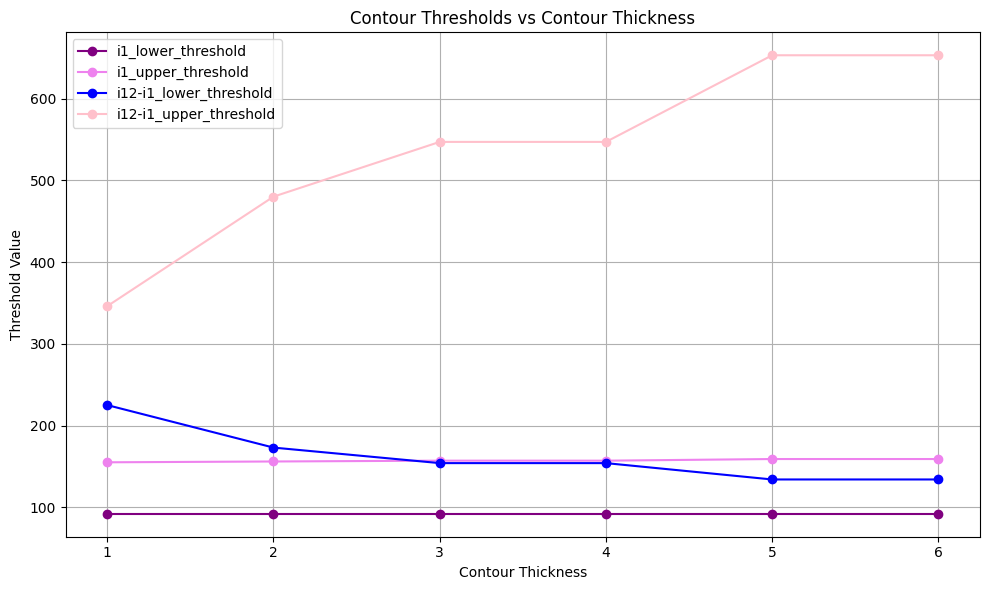

In [ ]:
# Plot contour thresholds
thicknesses = list(contour_thresholds_all.keys())
i1_lower_values = [contour_thresholds_all[t]['i1'][0] for t in thicknesses]
i1_upper_values = [contour_thresholds_all[t]['i1'][1] for t in thicknesses]
i12_lower_values = [contour_thresholds_all[t]['i12_minus_i1'][0] for t in thicknesses]
i12_upper_values = [contour_thresholds_all[t]['i12_minus_i1'][1] for t in thicknesses]

plt.figure(figsize=(10, 6))
plt.plot(thicknesses, i1_lower_values, color='purple', marker='o', label='i1_lower_threshold')
plt.plot(thicknesses, i1_upper_values, color='violet', marker='o', label='i1_upper_threshold')
plt.plot(thicknesses, i12_lower_values, color='blue', marker='o', label='i12-i1_lower_threshold')
plt.plot(thicknesses, i12_upper_values, color='pink', marker='o', label='i12-i1_upper_threshold')

plt.xlabel('Contour Thickness')
plt.ylabel('Threshold Value')
plt.title('Contour Thresholds vs Contour Thickness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
contour_thresholds_all

{1: {'i1': (92.0, 155.0), 'i12_minus_i1': (225.0, 346.0)},
 2: {'i1': (92.0, 156.0), 'i12_minus_i1': (173.0, 480.0)},
 3: {'i1': (92.0, 157.0), 'i12_minus_i1': (154.0, 547.0)},
 4: {'i1': (92.0, 157.0), 'i12_minus_i1': (154.0, 547.0)},
 5: {'i1': (92.0, 159.0), 'i12_minus_i1': (134.0, 653.0)},
 6: {'i1': (92.0, 159.0), 'i12_minus_i1': (134.0, 653.0)}}

In [ ]:
metrics


{1: {'Ink': {'IoU': 0.8980747796901063,
   'Precision': 0.9676970172813297,
   'Recall': 0.9258301510983619,
   'F1-Score': 0.9463007351446212},
  'Parchment': {'IoU': 0.9927369463632669,
   'Precision': 0.997631869085415,
   'Recall': 0.9950818683096417,
   'F1-Score': 0.9963552371275154}},
 2: {'Ink': {'IoU': 0.8857734089502166,
   'Precision': 0.9503296715068479,
   'Recall': 0.9287720280891671,
   'F1-Score': 0.9394271917783741},
  'Parchment': {'IoU': 0.9916797034460201,
   'Precision': 0.996014825287944,
   'Recall': 0.9956301941720139,
   'F1-Score': 0.9958224725895514}},
 3: {'Ink': {'IoU': 0.8883543023645858,
   'Precision': 0.9532376902765877,
   'Recall': 0.9288322266396908,
   'F1-Score': 0.940876721335815},
  'Parchment': {'IoU': 0.9917700232251101,
   'Precision': 0.9962234293096022,
   'Recall': 0.9955128412367523,
   'F1-Score': 0.9958680085155797}},
 4: {'Ink': {'IoU': 0.8883543023645858,
   'Precision': 0.9532376902765877,
   'Recall': 0.9288322266396908,
   'F1-Score

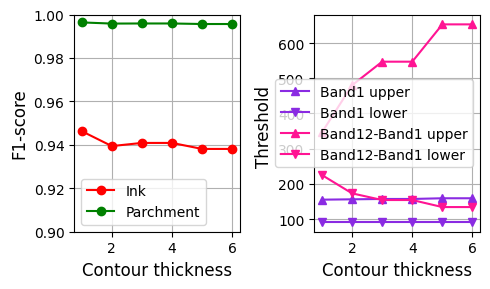

In [ ]:
import matplotlib.pyplot as plt

# Sample F1-scores for Ink and Parchment
f1_scores_ink = [metrics[thickness]['Ink']['F1-Score'] for thickness in thicknesses]
f1_scores_parchment = [metrics[thickness]['Parchment']['F1-Score'] for thickness in thicknesses]

# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

# # Plotting F1-Score vs Contour Thickness
# ax1.plot(thicknesses, f1_scores_ink, color='red', marker='o', label='Ink')
# ax1.plot(thicknesses, f1_scores_parchment, color='green', marker='o', label='Parchment')
# ax1.set_xlabel('Contour thickness', fontsize='larger')
# ax1.set_ylabel('F1-score', fontsize='larger')
# ax1.legend()
# ax1.grid(True)

ax1.plot(thicknesses, f1_scores_ink, color='red', marker='o', label='Ink')
ax1.plot(thicknesses, f1_scores_parchment, color='green', marker='o', label='Parchment')
ax1.set_xlabel('Contour thickness', fontsize='larger')
ax1.set_ylabel('F1-score', fontsize='larger')
ax1.legend()
# Set the y-axis limits and ticks
ax1.set_ylim(0.90, 1.0)
#ax1.set_yticks([i * 0.1 for i in range(0, 11)])
ax1.grid(True)


# Plotting Contour Thresholds vs Contour Thickness
i1_lower_values = [contour_thresholds_all[t]['i1'][0] for t in thicknesses]
i1_upper_values = [contour_thresholds_all[t]['i1'][1] for t in thicknesses]
i12_lower_values = [contour_thresholds_all[t]['i12_minus_i1'][0] for t in thicknesses]
i12_upper_values = [contour_thresholds_all[t]['i12_minus_i1'][1] for t in thicknesses]

ax2.plot(thicknesses, i1_upper_values, color='blueviolet', marker='^', label='Band1 upper')
ax2.plot(thicknesses, i1_lower_values, color='blueviolet', marker='v', label='Band1 lower')
ax2.plot(thicknesses, i12_upper_values, color='deeppink', marker='^', label='Band12-Band1 upper')
ax2.plot(thicknesses, i12_lower_values, color='deeppink', marker='v', label='Band12-Band1 lower')


ax2.set_xlabel('Contour thickness', fontsize='larger')
ax2.set_ylabel('Threshold ', fontsize='larger')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('performance_vs_contour_thickness.png', dpi=300, format='png')
plt.show()


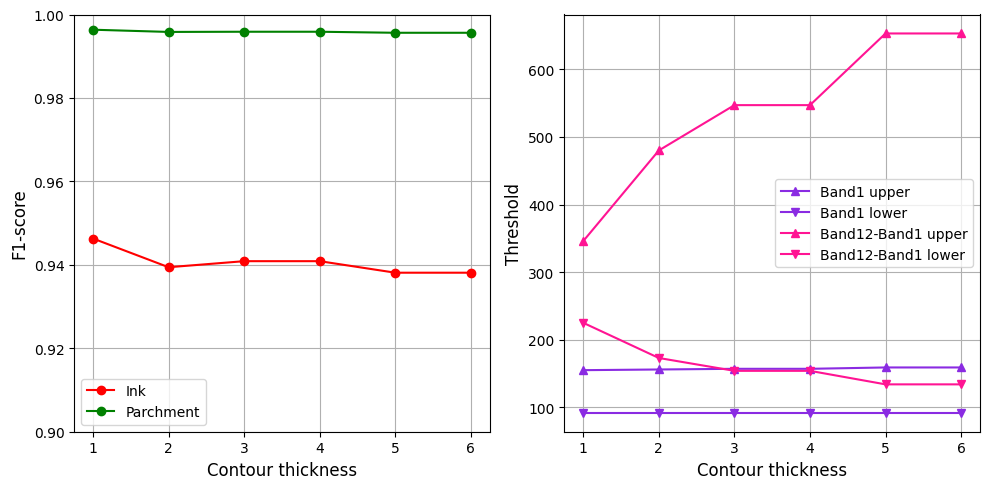

In [3]:
import matplotlib.pyplot as plt

# Provided data for contour thresholds and F1-scores
contour_thresholds_all = {
    1: {'i1': (92.0, 155.0), 'i12_minus_i1': (225.0, 346.0)},
    2: {'i1': (92.0, 156.0), 'i12_minus_i1': (173.0, 480.0)},
    3: {'i1': (92.0, 157.0), 'i12_minus_i1': (154.0, 547.0)},
    4: {'i1': (92.0, 157.0), 'i12_minus_i1': (154.0, 547.0)},
    5: {'i1': (92.0, 159.0), 'i12_minus_i1': (134.0, 653.0)},
    6: {'i1': (92.0, 159.0), 'i12_minus_i1': (134.0, 653.0)}
}

metrics = {
    1: {'Ink': {'F1-Score': 0.9463007351446212},
        'Parchment': {'F1-Score': 0.9963552371275154}},
    2: {'Ink': {'F1-Score': 0.9394271917783741},
        'Parchment': {'F1-Score': 0.9958224725895514}},
    3: {'Ink': {'F1-Score': 0.940876721335815},
        'Parchment': {'F1-Score': 0.9958680085155797}},
    4: {'Ink': {'F1-Score': 0.940876721335815},
        'Parchment': {'F1-Score': 0.9958680085155797}},
    5: {'Ink': {'F1-Score': 0.9381126844242005},
        'Parchment': {'F1-Score': 0.9956195397773967}},
    6: {'Ink': {'F1-Score': 0.9381126844242005},
        'Parchment': {'F1-Score': 0.9956195397773967}}
}

# Extracting thickness values, F1-scores for Ink and Parchment
thicknesses = list(metrics.keys())
f1_scores_ink = [metrics[t]['Ink']['F1-Score'] for t in thicknesses]
f1_scores_parchment = [metrics[t]['Parchment']['F1-Score'] for t in thicknesses]

# Extracting contour threshold values
i1_lower_values = [contour_thresholds_all[t]['i1'][0] for t in thicknesses]
i1_upper_values = [contour_thresholds_all[t]['i1'][1] for t in thicknesses]
i12_lower_values = [contour_thresholds_all[t]['i12_minus_i1'][0] for t in thicknesses]
i12_upper_values = [contour_thresholds_all[t]['i12_minus_i1'][1] for t in thicknesses]

# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plotting F1-Score vs Contour Thickness
ax1.plot(thicknesses, f1_scores_ink, color='red', marker='o', label='Ink')
ax1.plot(thicknesses, f1_scores_parchment, color='green', marker='o', label='Parchment')
ax1.set_xlabel('Contour thickness', fontsize='larger')
ax1.set_ylabel('F1-score', fontsize='larger')
ax1.legend()
ax1.set_ylim(0.90, 1.0)
ax1.grid(True)

# Plotting Contour Thresholds vs Contour Thickness
ax2.plot(thicknesses, i1_upper_values, color='blueviolet', marker='^', label='Band1 upper')
ax2.plot(thicknesses, i1_lower_values, color='blueviolet', marker='v', label='Band1 lower')
ax2.plot(thicknesses, i12_upper_values, color='deeppink', marker='^', label='Band12-Band1 upper')
ax2.plot(thicknesses, i12_lower_values, color='deeppink', marker='v', label='Band12-Band1 lower')
ax2.set_xlabel('Contour thickness', fontsize='larger')
ax2.set_ylabel('Threshold', fontsize='larger')
ax2.legend()
ax2.grid(True)

# Adjust layout, save and display plot
plt.tight_layout()
plt.savefig('performance_vs_contour_thickness.png', dpi=300, format='png')
plt.show()


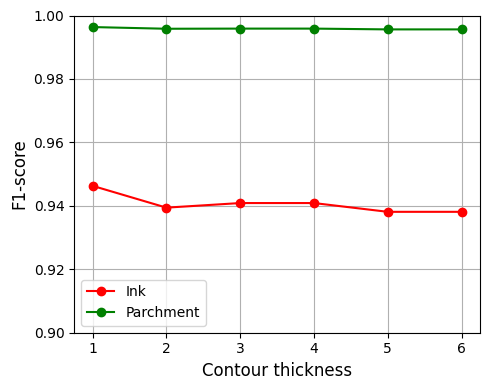

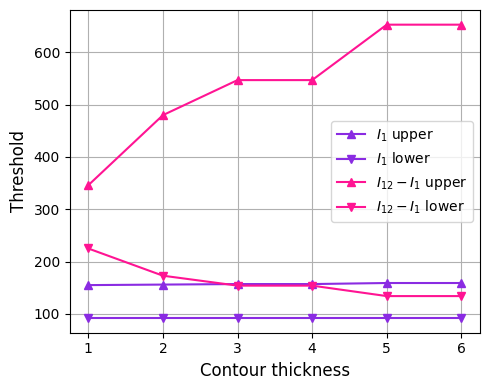

In [7]:
# Plotting the F1-Score vs Contour Thickness separately with updated labels
fig1, ax1 = plt.subplots(figsize=(5, 4))
ax1.plot(thicknesses, f1_scores_ink, color='red', marker='o', label='Ink')
ax1.plot(thicknesses, f1_scores_parchment, color='green', marker='o', label='Parchment')
ax1.set_xlabel('Contour thickness', fontsize='larger')
ax1.set_ylabel('F1-score', fontsize='larger')
ax1.legend()
ax1.set_ylim(0.90, 1.0)
ax1.grid(True)
plt.tight_layout()
plt.savefig('f1_score_vs_contour_thickness.png', dpi=300, format='png')
plt.show()

# Plotting the Contour Thresholds vs Contour Thickness separately with updated labels
fig2, ax2 = plt.subplots(figsize=(5, 4))
ax2.plot(thicknesses, i1_upper_values, color='blueviolet', marker='^', label=r'$I_1$ upper')
ax2.plot(thicknesses, i1_lower_values, color='blueviolet', marker='v', label=r'$I_1$ lower')
ax2.plot(thicknesses, i12_upper_values, color='deeppink', marker='^', label=r'$I_{12} - I_1$ upper')
ax2.plot(thicknesses, i12_lower_values, color='deeppink', marker='v', label=r'$I_{12} - I_1$ lower')
ax2.set_xlabel('Contour thickness', fontsize='larger')
ax2.set_ylabel('Threshold', fontsize='larger')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('contour_thresholds_vs_contour_thickness.png', dpi=300, format='png')
plt.show()
